In [276]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from utils.helpers.pandas_helpers import keep_levels, index_slice
from objects.signals.individual.momentum import Momentum
from objects.signals.individual.fair_value.pca import PCA
from objects.signals.combination.simple_combination import SignalSelector
from objects.signals.combination.ml_combination import MLSignalSelector
from objects.data_manipulation.normalizer import Normalizer
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [277]:

investment_universe = [
    'ADA/USDC:USDC',
    'DOT/USDC:USDC',
    'SOL/USDC:USDC',
    'XRP/USDC:USDC',
    'BTC/USDC:USDC',
    'ETH/USDC:USDC']

In [278]:
df= pd.read_parquet('/Users/educontreras/PycharmProjects/crypto_signals/objects/retriever/hourly_prices.parquet')
pca_df= pd.read_parquet('/Users/educontreras/PycharmProjects/crypto_signals/objects/retriever/fair_value.parquet')
df.columns = df.columns.rename("field", level=0)
close_df = keep_levels(index_slice(df, field = 'close'), ['symbol'])

df_subset = close_df.loc[:, investment_universe]
returns_df = df_subset.pct_change().dropna(how = 'any')

In [286]:
pca_df =  PCA.rolling_pca(df_subset, windows = [30, 60, 90], covariance_mode= 'exponential')

2024-12-23 17:31:35.940 | INFO     | objects.signals.individual.fair_value.pca:rolling_pca:25 - Starting rolling PCA computation
2024-12-23 17:31:35.949 | INFO     | objects.signals.individual.fair_value.pca:rolling_pca:31 - Processing rolling PCA for window size 30
2024-12-23 17:31:58.301 | INFO     | objects.signals.individual.fair_value.pca:rolling_pca:31 - Processing rolling PCA for window size 60
2024-12-23 17:32:20.490 | INFO     | objects.signals.individual.fair_value.pca:rolling_pca:31 - Processing rolling PCA for window size 90
2024-12-23 17:32:42.176 | SUCCESS  | objects.signals.individual.fair_value.pca:rolling_pca:106 - Rolling PCA computation completed


2024-12-23 17:35:41.407 | INFO     | objects.data_manipulation.normalizer:compute_z_scores:18 - Starting Z-Score computation
2024-12-23 17:35:41.407 | INFO     | objects.data_manipulation.normalizer:compute_z_scores:22 - Computing Z-Score for window size 90
2024-12-23 17:35:41.479 | SUCCESS  | objects.data_manipulation.normalizer:compute_z_scores:50 - Z-Score computation completed


<Axes: xlabel='timestamp'>

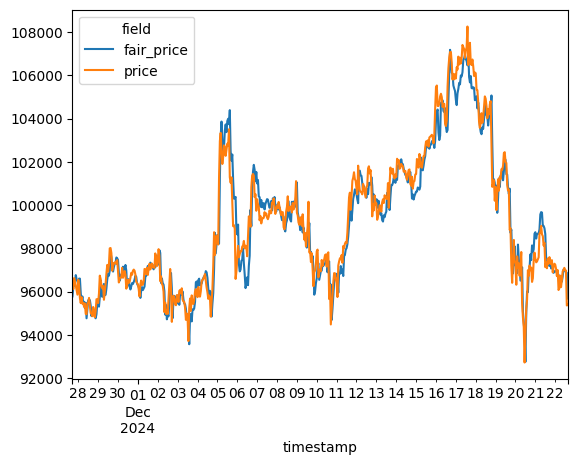

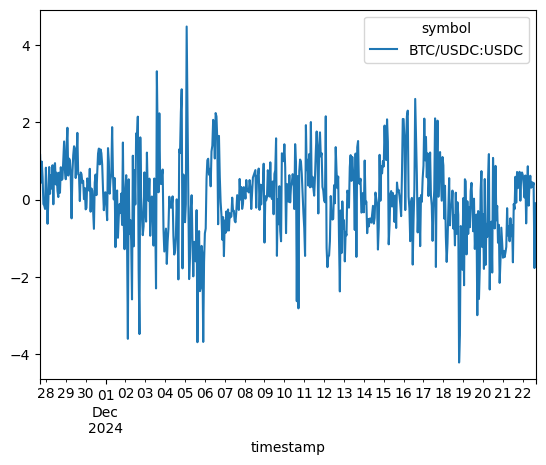

In [295]:
fv_df = keep_levels(index_slice(pca_df, symbol = 'BTC/USDC:USDC', period = 60, field = ['fair_price', 'price']), ['field']).dropna()
diff_df = keep_levels(index_slice(pca_df, period = 60, field = ['difference']), ['symbol']).dropna()
z_df = Normalizer.compute_z_scores(diff_df, windows = [90])
z_plot = keep_levels(index_slice(z_df, symbol = 'BTC/USDC:USDC', period = 90), ['symbol'])
fv_df.tail(600).plot()
z_plot.tail(600).plot()

In [301]:
p = Position.mean_reversion(z_df, -2, 0, 2, 0, number_days_confirmation=0)


<Axes: xlabel='timestamp'>

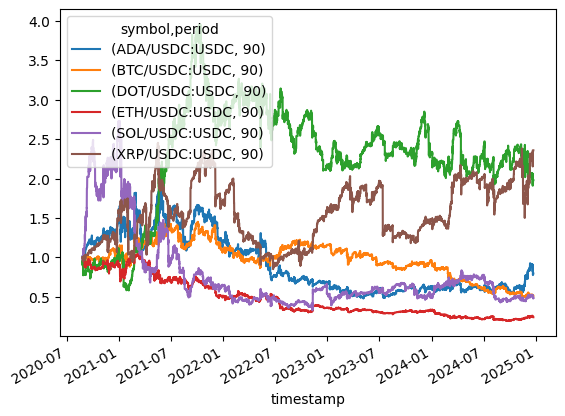

In [302]:
profits = p.shift(1) * returns_df
(profits + 1).cumprod().dropna().plot()